In [1]:
import torch
import numpy as np
import os
import sys
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [2]:
TRAIN_FILE = 'trainfile.txt'
VAL_FILE = 'valfile.txt'
TEST_FILE = 'testfile.txt'

IMG_PATH = 'flowers_data/jpg/'

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
log_interval = 1000
learning_rate = 0.01
momentum = 0.01
epochs = 30

In [4]:
class Flower102Dataset(Dataset):
    def __init__(self, train_file, val_file, test_file, img_path, train_val_test='train', transform = None):
        self.train_labels = {}
        self.val_labels = {}
        self.test_labels = {}
        self.train_val_test = train_val_test
        self.img_path = img_path
        self.transform = transform
        ctr = 0
        train_f = open(train_file, 'r')
        for line in train_f:
            img_name, label = line.split(" ")
            self.train_labels[ctr] = (img_name, int(label))
            ctr += 1
        ctr = 0
        val_f = open(val_file, 'r')
        for line in val_f:
            img_name, label = line.split(" ")
            self.val_labels[ctr] = (img_name, int(label))
            ctr += 1
        ctr = 0
        test_f = open(test_file, 'r')
        for line in test_f:
            img_name, label = line.split(" ")
            self.test_labels[ctr] = (img_name, int(label))
            ctr += 1
            
    def __len__(self):
        if self.train_val_test == 'train':
            return len(self.train_labels)
        elif self.train_val_test == 'val':
            return len(self.val_labels)
        elif self.train_val_test == 'test':
            return len(self.test_labels)
        
    def __getitem__(self, idx):
        image = None
        target = None
        if self.train_val_test == 'train':
            filename, target = self.train_labels[idx]
            image = io.imread(self.img_path + filename)
            if(len(image.shape) == 2):
                image = np.stack((image,)*3, axis=-1)
            if self.transform:
                image = self.transform(image)
                target = torch.Tensor([target]*5)
                target = target.long()
        elif self.train_val_test == 'val':
            filename, target = self.val_labels[idx]
            image = io.imread(self.img_path + filename)
            if(len(image.shape) == 2):
                image = np.stack((image,)*3, axis=-1)
            if self.transform:
                image = self.transform(image)
        elif self.train_val_test == 'test':
            filename, target = self.test_labels[idx]
            image = io.imread(self.img_path + filename)
            if(len(image.shape) == 2):
                image = np.stack((image,)*3, axis=-1)
            if self.transform:
                image = self.transform(image)
        return (image, target)
            


In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    total_data = len(train_loader.dataset)
    for data, target in train_loader:
        data = data.view([-1,data.shape[-3],data.shape[-2],data.shape[-1]])  
        data, target = data.to(device), target.to(device)
        target = target.view([-1])
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, len(train_loader.dataset), len(train_loader.dataset),
        100. * len(train_loader.dataset) / len(train_loader.dataset), loss.item()))
    return loss

In [25]:
def test(model, device, test_loader, log_freq = 100):
    model.eval()
    test_loss = 0
    correct = 0
    total_num_data = len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
        
            pred = output.argmax(dim=1, keepdim=True)
        
            correct += pred.eq(target.view_as(pred)).sum().item()
                 
    accuracy = 100. * correct / total_num_data
    print('\nPerformance: Accuracy: {}/{} ({:.2f}%), Loss: {:.6f}\n'.format(
        correct, total_num_data, accuracy, test_loss))
    return test_loss, accuracy

In [7]:
traintime_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(280),
        transforms.FiveCrop(224), 
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda norms: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(norm) for norm in norms]))
    ])

In [8]:
centercropnorm_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [9]:
flowers102train = Flower102Dataset(TRAIN_FILE, VAL_FILE, TEST_FILE, IMG_PATH, 'train', traintime_transform)
train_loader = DataLoader(flowers102train, batch_size=4,
                        shuffle=True, num_workers=0)

In [10]:
flowers102val = Flower102Dataset(TRAIN_FILE, VAL_FILE, TEST_FILE, IMG_PATH, 'val', centercropnorm_transform)
val_loader = DataLoader(flowers102val, batch_size=4,
                        shuffle=True, num_workers=0)

In [11]:
flowers102test = Flower102Dataset(TRAIN_FILE, VAL_FILE, TEST_FILE, IMG_PATH, 'test', centercropnorm_transform)
test_loader = DataLoader(flowers102test, batch_size=4,
                        shuffle=True, num_workers=0)

In [ ]:
print("Model without loading weights")

In [12]:
# No weights
resnet18 = models.resnet18(pretrained=False)
resnet18.cuda()
optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=momentum)

In [13]:
# No weights
x_epoch = []
train_loss_ot = []
val_loss_ot = []
val_acc_ot = []
best_loss = sys.maxsize
for epoch in range(1, epochs + 1):
    # training phase
    train_loss = train(resnet18, device, train_loader, optimizer, epoch, log_interval)
    x_epoch.append(epoch)
    train_loss_ot.append(train_loss)
    
    # validation phase
    current_loss, accuracy = test(resnet18, device, val_loader, log_interval)
    val_loss_ot.append(current_loss)
    val_acc_ot.append(accuracy)
    if current_loss <= best_loss:
        torch.save(resnet18.state_dict(),"flower102noweights.pt")
        best_loss = current_loss
        
        
print("Best Loss: {}".format(best_loss))

Train Epoch: 1 [5687/5687 (100%)]	Loss: 3.730564

Performance: Accuracy: 146/1224 (11.93%), Loss: 5102.593184

Train Epoch: 2 [5687/5687 (100%)]	Loss: 3.235626

Performance: Accuracy: 318/1224 (25.98%), Loss: 4127.380423

Train Epoch: 3 [5687/5687 (100%)]	Loss: 3.758488

Performance: Accuracy: 306/1224 (25.00%), Loss: 3935.562722

Train Epoch: 4 [5687/5687 (100%)]	Loss: 3.308613

Performance: Accuracy: 352/1224 (28.76%), Loss: 3839.329845

Train Epoch: 5 [5687/5687 (100%)]	Loss: 3.313563

Performance: Accuracy: 479/1224 (39.13%), Loss: 2971.998009

Train Epoch: 6 [5687/5687 (100%)]	Loss: 2.383286

Performance: Accuracy: 509/1224 (41.58%), Loss: 2925.073413

Train Epoch: 7 [5687/5687 (100%)]	Loss: 0.693751

Performance: Accuracy: 599/1224 (48.94%), Loss: 2338.176424

Train Epoch: 8 [5687/5687 (100%)]	Loss: 0.676356

Performance: Accuracy: 615/1224 (50.25%), Loss: 2366.503221

Train Epoch: 9 [5687/5687 (100%)]	Loss: 2.899636

Performance: Accuracy: 596/1224 (48.69%), Loss: 2592.403928

T

In [15]:
resnet18best = models.resnet18(pretrained=False)
resnet18best.cuda()
resnet18best.load_state_dict(torch.load("flower102noweights.pt", map_location=device))
loss = test(resnet18, device, test_loader, log_interval)


Performance: Accuracy: 1054/1278 (82.47%), Loss: 953.753869



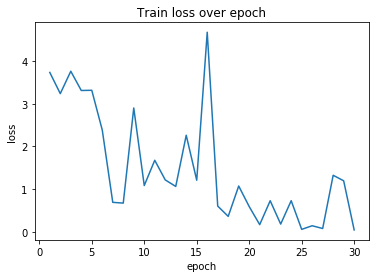

In [16]:
plt.title("Train loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, train_loss_ot)
plt.show()

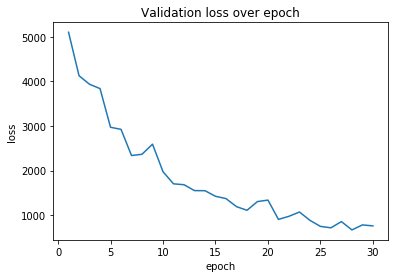

In [17]:
plt.title("Validation loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, val_loss_ot)
plt.show()

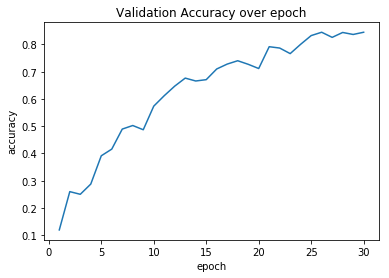

In [24]:
plt.title("Validation Accuracy over epoch")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x_epoch, val_acc_ot)
plt.show()

In [ ]:
print("Model without loading weights and training all levels")

In [28]:
# Full weights
resnet18loaded = models.resnet18(pretrained=True)
resnet18loaded.cuda()
optimizer = optim.SGD(resnet18loaded.parameters(), lr=learning_rate, momentum=momentum)

In [29]:
# Full weights
x_epoch = []
train_loss_ot = []
val_loss_ot = []
val_acc_ot = []
best_loss = sys.maxsize
for epoch in range(1, epochs + 1):
    # training phase
    train_loss = train(resnet18loaded, device, train_loader, optimizer, epoch, log_interval)
    x_epoch.append(epoch)
    train_loss_ot.append(train_loss)
    
    # validation phase
    current_loss, accuracy = test(resnet18loaded, device, val_loader, log_interval)
    val_loss_ot.append(current_loss)
    val_acc_ot.append(accuracy)
    if current_loss <= best_loss:
        torch.save(resnet18loaded.state_dict(),"flower102fullweights.pt")
        best_loss = current_loss
        
        
print("Best Loss: {}".format(best_loss))

Train Epoch: 1 [5687/5687 (100%)]	Loss: 3.106496

Performance: Accuracy: 1000/1224 (81.70%), Loss: 802.353889

Train Epoch: 2 [5687/5687 (100%)]	Loss: 0.223955

Performance: Accuracy: 1146/1224 (93.63%), Loss: 294.661448

Train Epoch: 3 [5687/5687 (100%)]	Loss: 0.250084

Performance: Accuracy: 1161/1224 (94.85%), Loss: 200.938255

Train Epoch: 4 [5687/5687 (100%)]	Loss: 0.101890

Performance: Accuracy: 1175/1224 (96.00%), Loss: 179.085724

Train Epoch: 5 [5687/5687 (100%)]	Loss: 0.351579

Performance: Accuracy: 1172/1224 (95.75%), Loss: 181.348999

Train Epoch: 6 [5687/5687 (100%)]	Loss: 0.161734

Performance: Accuracy: 1173/1224 (95.83%), Loss: 161.515744

Train Epoch: 7 [5687/5687 (100%)]	Loss: 0.022329

Performance: Accuracy: 1184/1224 (96.73%), Loss: 138.663336

Train Epoch: 8 [5687/5687 (100%)]	Loss: 0.663267

Performance: Accuracy: 1169/1224 (95.51%), Loss: 201.071285

Train Epoch: 9 [5687/5687 (100%)]	Loss: 0.091364

Performance: Accuracy: 1175/1224 (96.00%), Loss: 158.959114

T

In [30]:
resnet18best = models.resnet18(pretrained=False)
resnet18best.cuda()
resnet18best.load_state_dict(torch.load("flower102fullweights.pt", map_location=device))
loss = test(resnet18, device, test_loader, log_interval)


Performance: Accuracy: 1054/1278 (82.47%), Loss: 953.753871



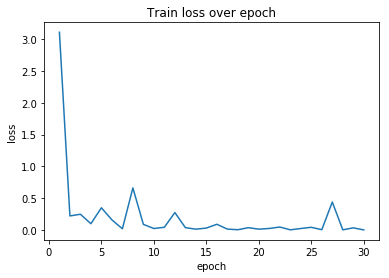

In [31]:
plt.title("Train loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, train_loss_ot)
plt.show()

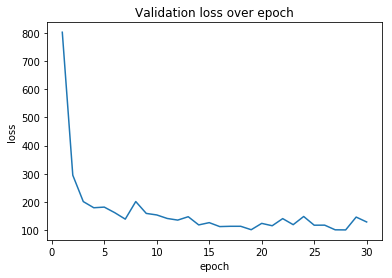

In [32]:
plt.title("Validation loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, val_loss_ot)
plt.show()

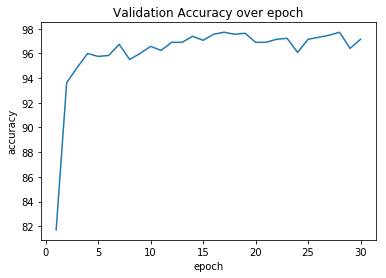

In [33]:
plt.title("Validation Accuracy over epoch")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x_epoch, val_acc_ot)
plt.show()

In [ ]:
print("Model without loading weights and training on last 2 layers")

In [35]:
# Full weights with freeze
resnet18freeze = models.resnet18(pretrained=True)
for p in resnet18freeze.conv1.parameters():
    p.requires_grad_(False)
for p in resnet18freeze.layer1.parameters(): #freeze layer 1
    p.requires_grad_(False)
for p in resnet18freeze.layer2.parameters(): # freeze Layer 2
    p.requires_grad_(False)
for p in resnet18freeze.layer3.parameters():
    p.requires_grad_(False)
resnet18freeze.cuda()
optimizer = optim.SGD(resnet18freeze.parameters(), lr=learning_rate, momentum=momentum)

In [36]:
# Full weights with freeze
x_epoch = []
train_loss_ot = []
val_loss_ot = []
val_acc_ot = []
best_loss = sys.maxsize
for epoch in range(1, epochs + 1):
    # training phase
    train_loss = train(resnet18freeze, device, train_loader, optimizer, epoch, log_interval)
    x_epoch.append(epoch)
    train_loss_ot.append(train_loss)
    
    # validation phase
    current_loss, accuracy = test(resnet18freeze, device, val_loader, log_interval)
    val_loss_ot.append(current_loss)
    val_acc_ot.append(accuracy)
    if current_loss <= best_loss:
        torch.save(resnet18freeze.state_dict(),"flower102freeze.pt")
        best_loss = current_loss
        
        
print("Best Loss: {}".format(best_loss))

Train Epoch: 1 [5687/5687 (100%)]	Loss: 1.511928

Performance: Accuracy: 1115/1224 (91.09%), Loss: 408.402533

Train Epoch: 2 [5687/5687 (100%)]	Loss: 0.977143

Performance: Accuracy: 1148/1224 (93.79%), Loss: 262.865331

Train Epoch: 3 [5687/5687 (100%)]	Loss: 2.399775

Performance: Accuracy: 1169/1224 (95.51%), Loss: 203.600915

Train Epoch: 4 [5687/5687 (100%)]	Loss: 0.191064

Performance: Accuracy: 1171/1224 (95.67%), Loss: 180.551285

Train Epoch: 5 [5687/5687 (100%)]	Loss: 0.226763

Performance: Accuracy: 1180/1224 (96.41%), Loss: 157.041892

Train Epoch: 6 [5687/5687 (100%)]	Loss: 0.066794

Performance: Accuracy: 1176/1224 (96.08%), Loss: 153.783568

Train Epoch: 7 [5687/5687 (100%)]	Loss: 0.040765

Performance: Accuracy: 1177/1224 (96.16%), Loss: 161.649790

Train Epoch: 8 [5687/5687 (100%)]	Loss: 0.067065

Performance: Accuracy: 1182/1224 (96.57%), Loss: 159.336577

Train Epoch: 9 [5687/5687 (100%)]	Loss: 0.113443

Performance: Accuracy: 1178/1224 (96.24%), Loss: 165.357356

T

In [37]:
resnet18best = models.resnet18(pretrained=False)
resnet18best.cuda()
resnet18best.load_state_dict(torch.load("flower102freeze.pt", map_location=device))
loss = test(resnet18, device, test_loader, log_interval)


Performance: Accuracy: 1054/1278 (82.47%), Loss: 953.753873



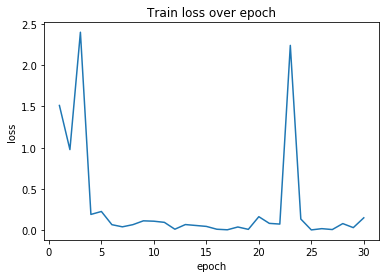

In [38]:
plt.title("Train loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, train_loss_ot)
plt.show()

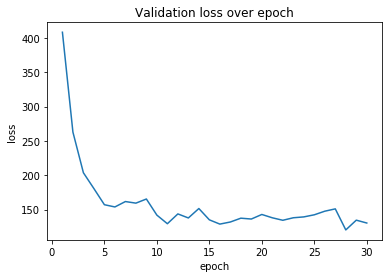

In [39]:
plt.title("Validation loss over epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x_epoch, val_loss_ot)
plt.show()

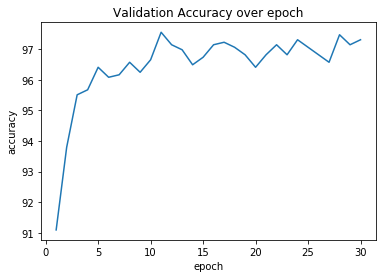

In [40]:
plt.title("Validation Accuracy over epoch")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x_epoch, val_acc_ot)
plt.show()